## Install Required Libraries

In [1]:
!pip install -q ucimlrepo
!pip install -q optuna
!pip install -q shap
!pip install -q lime



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Import Required Libraries  

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler

import optuna
from sklearn.pipeline import Pipeline

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score, confusion_matrix)

# Classifiers
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import (RandomForestClassifier,
                             ExtraTreesClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

import joblib
from sklearn.inspection import permutation_importance

import lime
import lime.lime_tabular

import shap

import warnings
warnings.filterwarnings('ignore')
import random
import os
# Ensure reproducibility for joblib-based models (e.g., scikit-learn)
os.environ["PYTHONHASHSEED"] = "145"





## Download Dermatology Dataset

In [5]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
dermatology = fetch_ucirepo(id=33)

# data (as pandas dataframes)
X = dermatology.data.features
y = dermatology.data.targets


## Preparing Data for Modeling

- Train-Test Split

  We must perform a train-test split before data preprocessing to avoid **data leakage** for standardization, imputation and so forth!

In [6]:
#Splitting the set


# Split the dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shape of the splits
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (292, 34)
Testing set shape: (74, 34)


- Finding Data Points with Null Entry

In [7]:
X_train[X_train['age'].isnull()]

,erythema,scaling,definite-borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral-mucosal involvement,knee elbow involvement,scalp involvement,...,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of the basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear infiltrate,band-like infiltrate,age
263,1,1,1,3,0,0,0,0,0,0,...,0,0,0,3,0,0,0,2,0,NaN
34,2,1,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
36,2,1,2,3,2,3,0,2,0,0,...,1,0,2,0,2,0,0,0,3,NaN
265,1,1,0,3,0,0,0,0,0,0,...,0,0,0,2,0,0,0,3,0,NaN
33,2,2,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,NaN


In [8]:
X_test[X_test['age'].isnull()]

,erythema,scaling,definite-borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral-mucosal involvement,knee elbow involvement,scalp involvement,...,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of the basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear infiltrate,band-like infiltrate,age
35,2,2,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
264,1,1,0,2,0,0,0,0,1,0,...,0,0,0,2,0,0,0,3,0,NaN
262,2,1,0,2,0,0,0,0,0,0,...,0,0,0,2,0,0,0,3,0,NaN


## Imputation

The age attribute has missing values. In this part we handle the missing values by comparing different imputation methods: median, mean and KNN imputations. The original study used median imputation, but we would like to explore other methods too.

In [9]:
# Median Imputation (used in original study)
median_imputer = SimpleImputer(strategy='median')
X_median = pd.DataFrame(median_imputer.fit_transform(X_train), columns=X.columns)

# Mean Imputation
mean_imputer = SimpleImputer(strategy='mean')
X_mean = pd.DataFrame(mean_imputer.fit_transform(X_train), columns=X.columns)

# KNN Imputation (k=5)
knn_imputer = KNNImputer(n_neighbors=5)
X_knn = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X.columns)

# Extract imputed age values
original_age = X['age'].copy()
imputed_age = {
    'Median': X_median['age'],
    'Mean': X_mean['age'],
    'KNN': X_knn['age'],
}

# Compare summary statistics
stats = pd.DataFrame({
    method: imputed_age[method].describe()[['mean', 'std', 'min', '50%', 'max']]
    for method in imputed_age
})
print(stats.T)


             mean        std  min   50%   max
Median  36.688356  15.554653  0.0  36.0  75.0
Mean    36.700348  15.554386  0.0  36.0  75.0
KNN     36.660959  15.601171  0.0  36.0  75.0


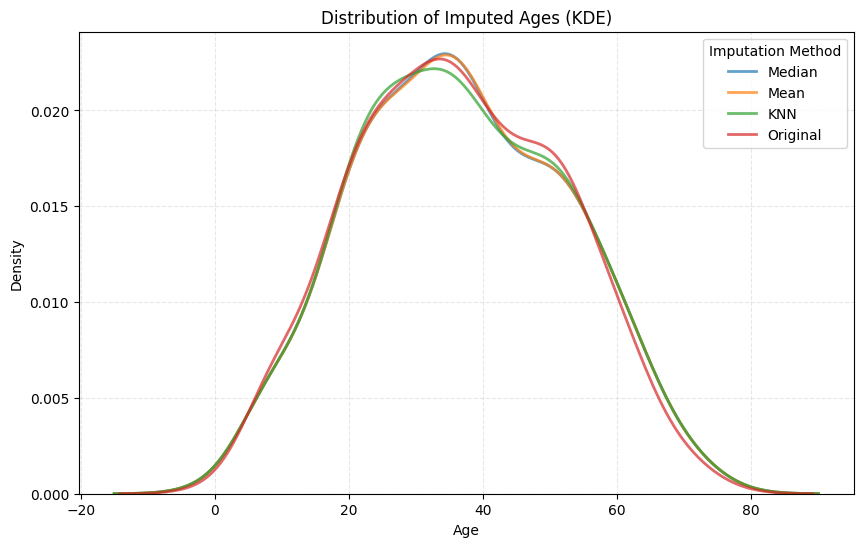

In [10]:
plt.figure(figsize=(10, 6))
for method, ages in imputed_age.items():
    sns.kdeplot(ages, label=method, alpha=0.7, linewidth=2)
sns.kdeplot(original_age, label='Original', alpha=0.7, linewidth=2)
plt.title("Distribution of Imputed Ages (KDE)")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend(title="Imputation Method")
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig('imputed_ages.png')
plt.show()


In general, Median Imputation preserves original distribution but ignores relationship with other features. MEan Imputation smooths out variability, and may distort the original distribution, KNN Imputation leverages feature correlations but is sensitive to outliers.

In this case, the probability density distribution of the 'age' variable shows significant overlap between values. To preserve the original age distribution, we chose the simplest imputation method: using the median. This approach ensures that the age variable remains consistent with the dataset's overall structure and avoids introducing bias.

- apply median imputer

In [11]:
median_imputer = SimpleImputer(strategy="median")
median_imputer.fit(X_train[["age"]])

# Transform both train and test sets using the SAME imputer
X_train["age"] = median_imputer.transform(X_train[["age"]])
X_test["age"] = median_imputer.transform(X_test[["age"]])


In [12]:
X_train[X_train['age'].isnull()]

,erythema,scaling,definite-borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral-mucosal involvement,knee elbow involvement,scalp involvement,...,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of the basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear infiltrate,band-like infiltrate,age


In [13]:
X_test[X_test['age'].isnull()]

,erythema,scaling,definite-borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral-mucosal involvement,knee elbow involvement,scalp involvement,...,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of the basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear infiltrate,band-like infiltrate,age


 ## Training/cross validation pipeline
 - Baysian Optimization for Hyperparameter Tuning (Optuna)

This code snippet focuses on training and evaluating several machine learning models to find the best one for the dermatology dataset.

In [14]:
y_train = y_train['class'] - 1
y_test = y_test['class'] - 1

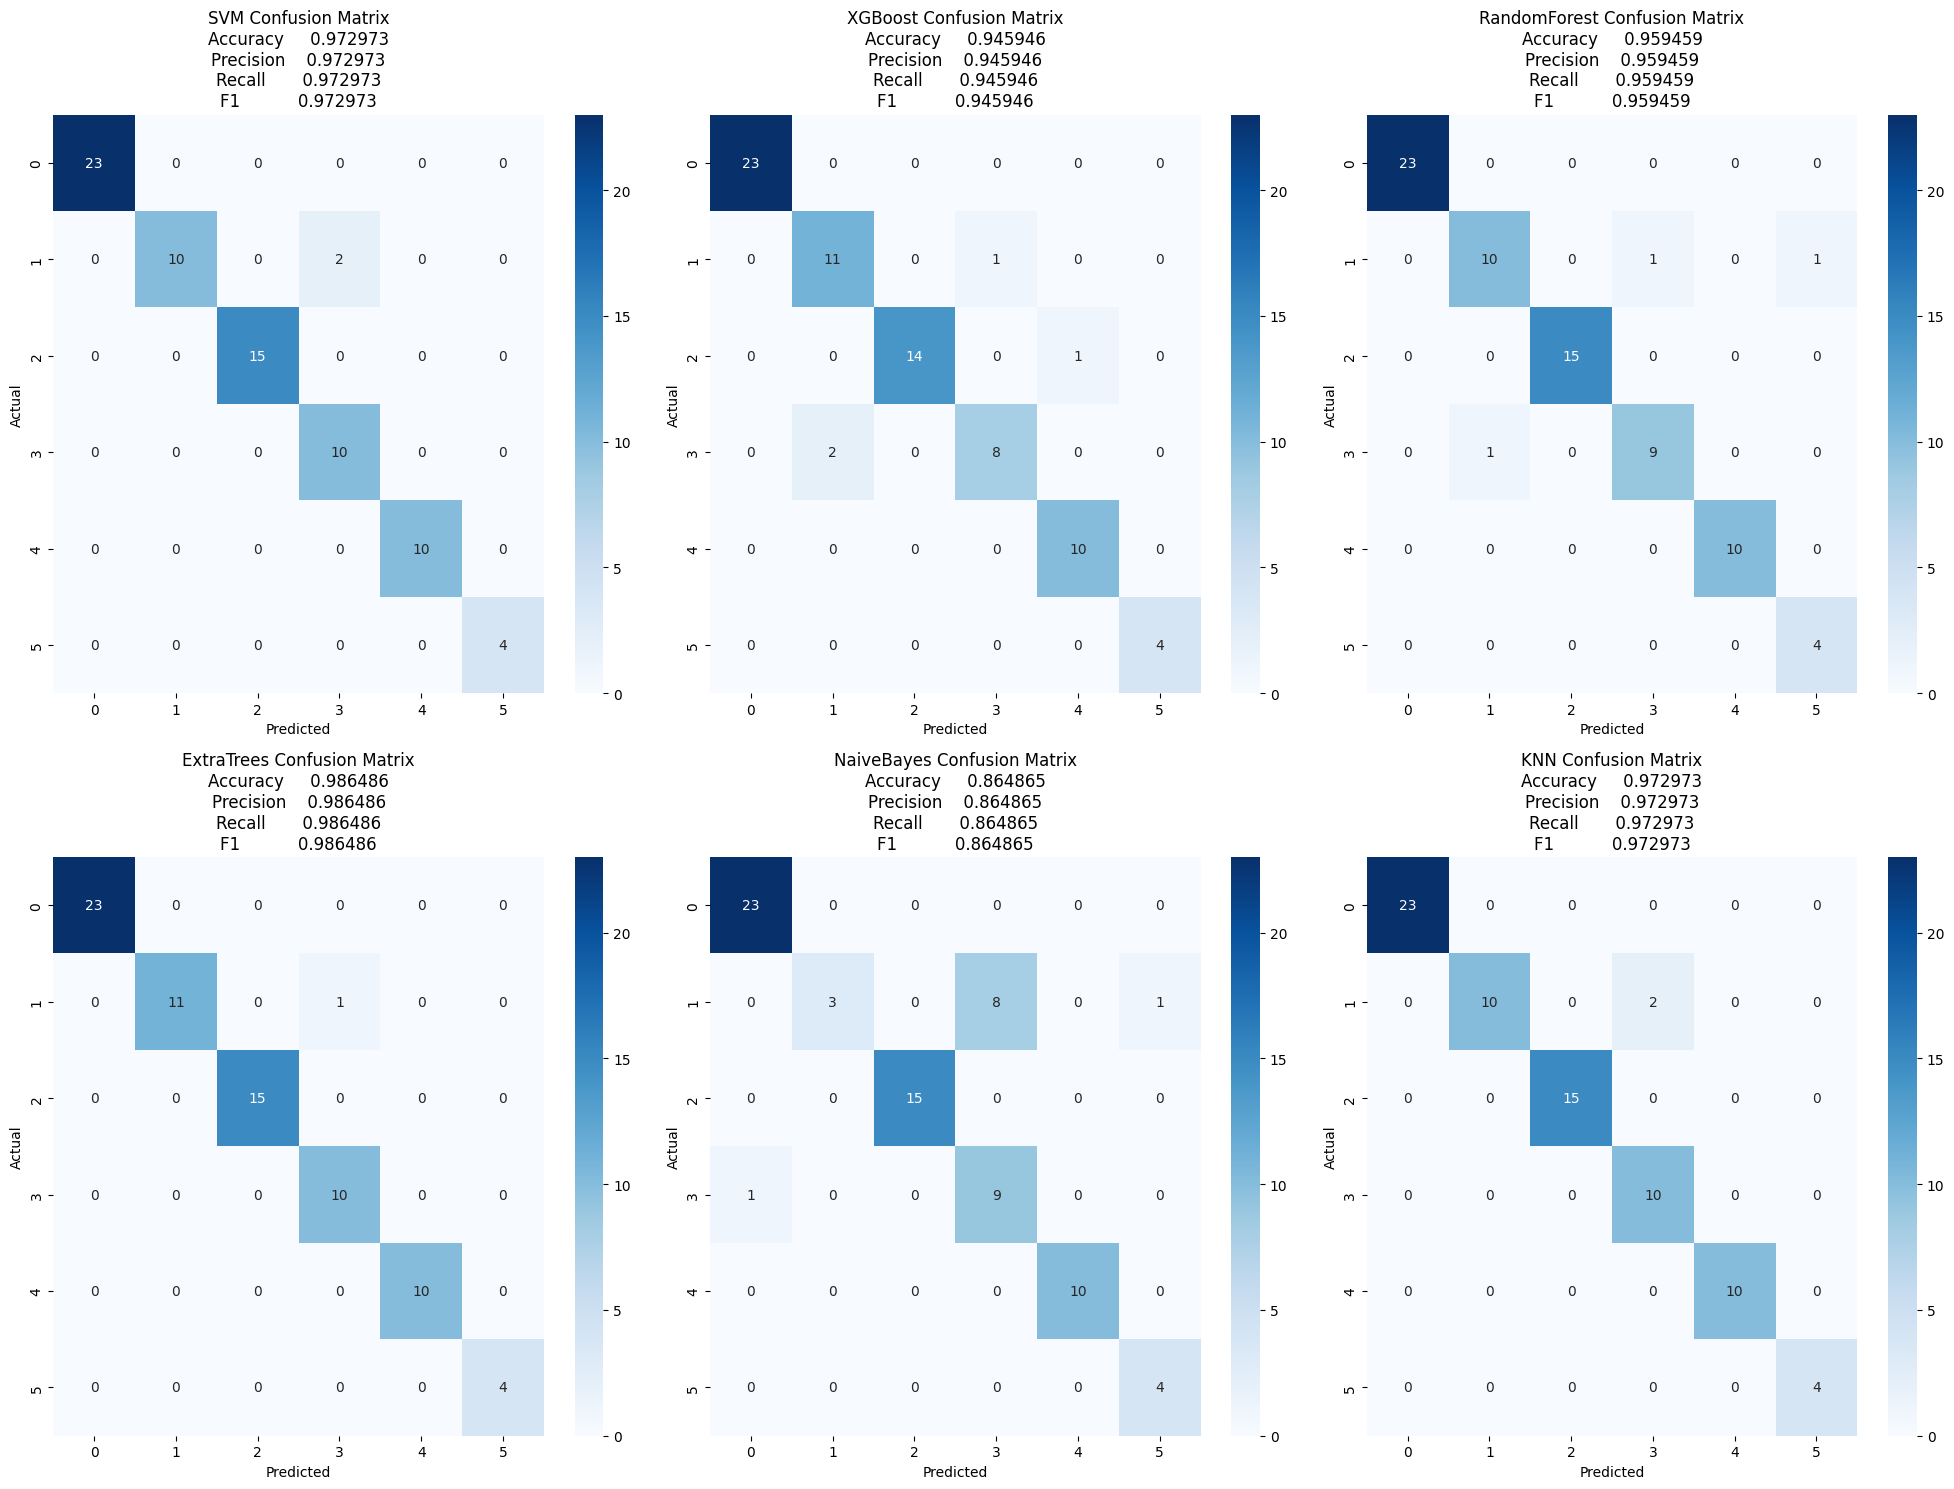

Best Parameters:

SVM:
{'C': 0.0436580554487485, 'kernel': 'linear', 'gamma': 0.003953417416401371}

XGBoost:
{'learning_rate': 0.01007154652731561, 'max_depth': 5, 'subsample': 0.5183372924273133, 'colsample_bytree': 0.7032160519056353, 'scale_pos_weight': 2.2808988764044944}

RandomForest:
{'n_estimators': 260, 'max_depth': 5, 'min_samples_split': 7}

ExtraTrees:
{'n_estimators': 285, 'max_depth': 5, 'min_samples_split': 4}

NaiveBayes:
No hyperparameters

KNN:
{'n_neighbors': 4, 'p': 1}

Performance Comparison:
              Accuracy  Precision    Recall        F1
Model                                                
ExtraTrees    0.986486   0.986486  0.986486  0.986486
SVM           0.972973   0.972973  0.972973  0.972973
KNN           0.972973   0.972973  0.972973  0.972973
RandomForest  0.959459   0.959459  0.959459  0.959459
XGBoost       0.945946   0.945946  0.945946  0.945946
NaiveBayes    0.864865   0.864865  0.864865  0.864865


In [15]:

# Initialize results storage
results = []
best_params = {}
confusion_matrices = {}

# Set seed for Python's built-in random module
random.seed(145)

# Set seed for NumPy
np.random.seed(145)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))



# Define model configurations
models = {
    'SVM': {
        'model': SVC(decision_function_shape='ovr', max_iter=10000, class_weight=class_weights_dict),
        'params': {
            'C': (1e-3, 1e3, 'log'),
            'kernel': ['linear', 'rbf'],
            'gamma': (1e-4, 1, 'log')
        }
    },
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train))),
        'params': {
            'learning_rate': (0.01, 1.0, 'log'),
            'max_depth': (3, 10, 'int'),
            'subsample': (0.5, 1.0, 'float'),
            'colsample_bytree': (0.5, 1.0, 'float'),
            'scale_pos_weight': [len(y_train[y_train != i]) / len(y_train[y_train == i]) for i in np.unique(y_train)]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(class_weight=class_weights_dict),
        'params': {
            'n_estimators': (100, 500, 'int'),
            'max_depth': (3, 15, 'int'),
            'min_samples_split': (2, 10, 'int')
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesClassifier(class_weight=class_weights_dict),
        'params': {
            'n_estimators': (100, 500, 'int'),
            'max_depth': (3, 15, 'int'),
            'min_samples_split': (2, 10, 'int')
        }
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'params': {}
    },
    'KNN': {
        'model': KNeighborsClassifier(weights='distance'),  # Use distance weighting
        'params': {
            'n_neighbors': (3, 15, 'int'),
            'p': [1, 2]  # 1=Manhattan, 2=Euclidean
        }
    }
}

#Hyperparameter Optimization with Optuna
def objective(trial, model_name):
    config = models[model_name]
    model = config['model'].set_params(**config['model'].get_params())  # Reset model

    params = {}
    for param, spec in config['params'].items():
        if isinstance(spec, tuple):
            low, high, param_type = spec
            if param_type == 'log':
                params[param] = trial.suggest_float(param, low, high, log=True)
            elif param_type == 'int':
                params[param] = trial.suggest_int(param, low, high)
            elif param_type == 'float':
                params[param] = trial.suggest_float(param, low, high)
        elif isinstance(spec, list):
            params[param] = trial.suggest_categorical(param, spec)

    # Create pipeline
    if model_name in ['SVM', 'KNN']:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model.set_params(**params))
        ])
    else:
        pipeline = Pipeline([
            ('model', model.set_params(**params))
        ])

    # Cross-validation with error handling
    try:
        score = cross_val_score(
            pipeline, X_train, y_train,
            cv=5, scoring='accuracy', n_jobs=-1,
            error_score='raise'
        ).mean()
    except Exception as e:
        print(f"Error in {model_name}: {str(e)}")
        score = -1  # Return invalid score for pruning

    return score


optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optimization and evaluation loop
for model_name in models.keys():
    if model_name == 'NaiveBayes':
        # Create proper pipeline for NaiveBayes
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', GaussianNB())
        ])
        pipeline.fit(X_train, y_train)
        best_params[model_name] = "No hyperparameters"
    else:
        sampler = optuna.samplers.TPESampler(seed=145)
        study = optuna.create_study(direction='maximize', sampler=sampler)
        study.optimize(
            lambda trial: objective(trial, model_name),
            n_trials=50,
            n_jobs=-1
        )
        best_params[model_name] = study.best_params

        ## Create proper pipeline with best params
        if model_name in ['SVM', 'KNN']:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                 ('model', models[model_name]['model'].set_params(**study.best_params))
            ])
        else:
            pipeline = Pipeline([
                ('model', models[model_name]['model'].set_params(**study.best_params))
            ])

        pipeline.fit(X_train, y_train)

    # Evaluation
    y_pred = pipeline.predict(X_test)

    # Store metrics
    results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='micro'),
        'Recall': recall_score(y_test, y_pred, average='micro'),
        'F1': f1_score(y_test, y_pred, average='micro')
    })

    # Store confusion matrix
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)


# Results DataFrame
results_df = pd.DataFrame(results).set_index('Model')

# Plot confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
for (name, cm), ax in zip(confusion_matrices.items(), axes.flatten()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix\n{results_df.loc[name].to_string()}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrices.png')

plt.show()

# Print best parameters
print("Best Parameters:")
for model, params in best_params.items():
    print(f"\n{model}:")
    print(params if isinstance(params, dict) else "No hyperparameters")

# Display results
print("\nPerformance Comparison:")
print(results_df.sort_values('F1', ascending=False))

## Cross-validation Interpretation

Our results show that the **Extra Trees Classifier** performed the best, achieving an **accuracy, precision, recall, and F1-score of 0.986486**. This suggests that it consistently makes correct predictions across all classes, outperforming models like KNN, Naïve Bayes, and XGBoost. The **SVM and Random Forest classifiers** also performed well, but Extra Trees had the best overall performance. Looking at class 6 (the rare class), Extra Trees successfully identified **4 instances correctly** with no misclassifications, demonstrating its strength in handling imbalanced data. This suggests that the model benefits from its **ensemble nature and ability to reduce overfitting**, making it the most reliable choice for this dataset.



In [16]:
import joblib
# After hyperparameter tuning and model evaluation

# 1. Identify best model
best_model_name = results_df.sort_values('F1', ascending=False).index[0]
print(best_model_name)

# 2. Reconstruct best pipeline with optimized parameters
if best_model_name in ['SVM', 'KNN', 'NaiveBayes']:
    best_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', models[best_model_name]['model'])
    ])
    if best_model_name != 'NaiveBayes':
        best_pipeline.set_params(**best_params[best_model_name])
else:
    best_pipeline = Pipeline([
        ('model', models[best_model_name]['model'].set_params(**best_params[best_model_name]))
    ])

# 3. Train on full data
best_pipeline.fit(X_train, y_train)

# 4. Save the entire pipeline (including preprocessing)
joblib.dump(best_pipeline, 'best_model.joblib')

# --- Later, to load and use ---
loaded_pipeline = joblib.load('best_model.joblib')

# Make predictions (automatically applies preprocessing)
new_sample = [X_test.iloc[0,:].values]
prediction = loaded_pipeline.predict(new_sample)
prediction

ExtraTrees


array([1])

## Feature Importance

<Figure size 2000x1500 with 0 Axes>

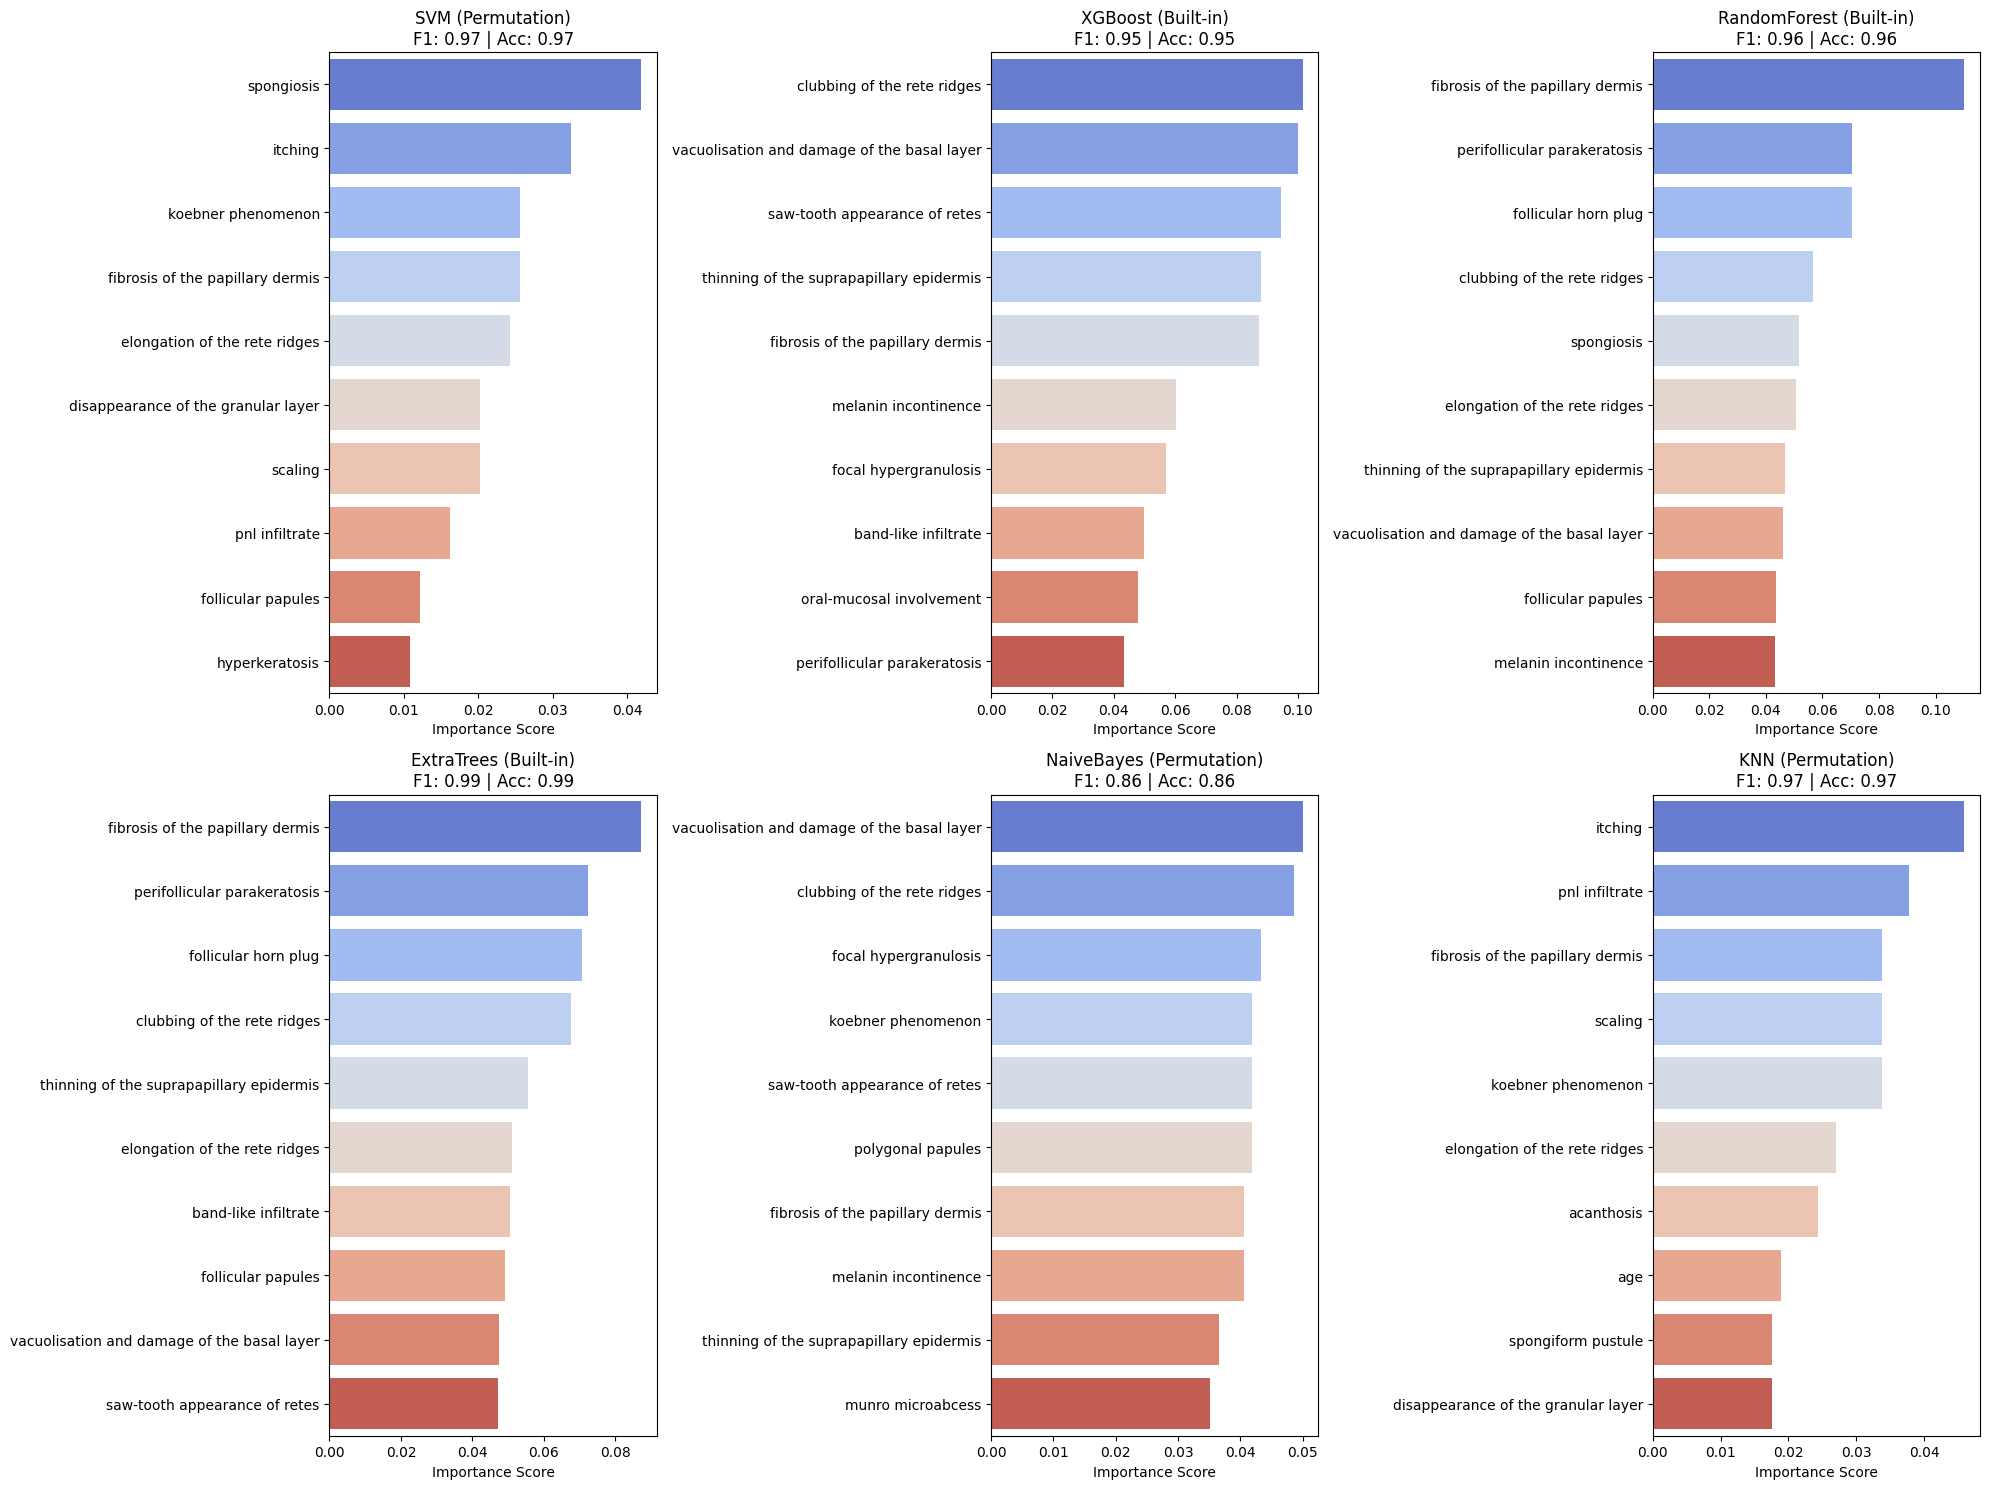

In [17]:
# Get feature names (assuming X is a DataFrame)
feature_names = X.columns.tolist()

# Create subplots for feature importance visualization
plt.figure(figsize=(20, 15))

# Initialize pipelines with best parameters
best_pipelines = {}

for model_name in models.keys():
    if model_name == 'NaiveBayes':
        # Naive Bayes doesn't have tuned parameters
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', GaussianNB())
        ])
    else:
        # Get optimized parameters from best_params
        model_params = best_params.get(model_name, {})

        # Rebuild pipeline with best parameters
        if model_name in ['SVM', 'KNN']:
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', models[model_name]['model'].set_params(**model_params))
            ])
        else:
            pipeline = Pipeline([
                ('model', models[model_name]['model'].set_params(**model_params))
            ])

    # Fit with best parameters
    pipeline.fit(X_train, y_train)
    best_pipelines[model_name] = pipeline

# Create feature importance plots
plt.figure(figsize=(20, 15))

# Plot feature importance for each model with its best parameters
for idx, (model_name, pipeline) in enumerate(best_pipelines.items(), 1):
    plt.subplot(2, 3, idx)

    # Add model performance metrics from results_df
    model_perf = results_df.loc[model_name]
    perf_text = f"F1: {model_perf['F1']:.2f} | Acc: {model_perf['Accuracy']:.2f}"

    try:
        # Feature importance calculation
        if hasattr(pipeline.named_steps['model'], 'feature_importances_'):
            importances = pipeline.named_steps['model'].feature_importances_
            importance_type = "Built-in"
        else:
            result = permutation_importance(
                pipeline, X_test, y_test,
                n_repeats=10,
                random_state=42,
                n_jobs=-1
            )
            importances = result.importances_mean
            importance_type = "Permutation"

        # Create and plot importance data
        feat_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False).head(10)

        sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='coolwarm')
        plt.title(f'{model_name} ({importance_type})\n{perf_text}')
        plt.xlabel('Importance Score')
        plt.ylabel('')

    except Exception as e:
        print(f"Feature importance failed for {model_name}: {str(e)}")
        plt.title(f"{model_name}\nFeature Importance Not Available\n{perf_text}")
        plt.axis('off')

plt.tight_layout()
plt.savefig('feature_importance_with_best_params.png')
plt.show()


The figure illustrates feature importance rankings derived from several classifiers (SVM, XGBoost, Random Forest, ExtraTrees, Naive Bayes, and KNN). Across the models, certain features consistently appear as highly important, such as "fibrosis of the papillary dermis," "vacuolisation and damage of the basal layer," and "clubbing of the rete ridges." This consistency suggests these features are critical for distinguishing dermatological conditions regardless of the classifier used. For example, "fibrosis of the papillary dermis" is ranked highly by SVM, Random Forest, and ExtraTrees, while "vacuolisation and damage of the basal layer" is particularly emphasized by XGBoost and Naive Bayes.

Moreover, there are variations in feature importance across models. For instance, SVM highlights "spongiform pustule" and "spongiosis," whereas XGBoost and Naive Bayes prioritize structural changes like "saw-tooth appearance of rete ridges" or "melanin incontinence." These differences reflect how each algorithm processes data and identifies patterns. Additionally, permutation-based methods (e.g., SVM, Naive Bayes, KNN) focus on different features compared to built-in importance measures (e.g., XGBoost, Random Forest). This highlights the need for careful selection of feature importance techniques depending on the model and interpretability goals.

In [18]:
# Identify the model name with the highest accuracy
pipeline_scores = {}  # Create an empty dictionary to store pipeline scores

for model_name, pipeline in best_pipelines.items():
    y_pred = pipeline.predict(X_test)
    pipeline_scores[model_name] = accuracy_score(y_test, y_pred)  # Store the accuracy score

best_model_name = max(pipeline_scores, key=pipeline_scores.get)
best_pipeline = best_pipelines[best_model_name]

print(f"The best model is {best_model_name} with accuracy {pipeline_scores[best_model_name]:.4f}")

The best model is ExtraTrees with accuracy 0.9865


## LIME Interpretation

<Figure size 2000x1000 with 0 Axes>

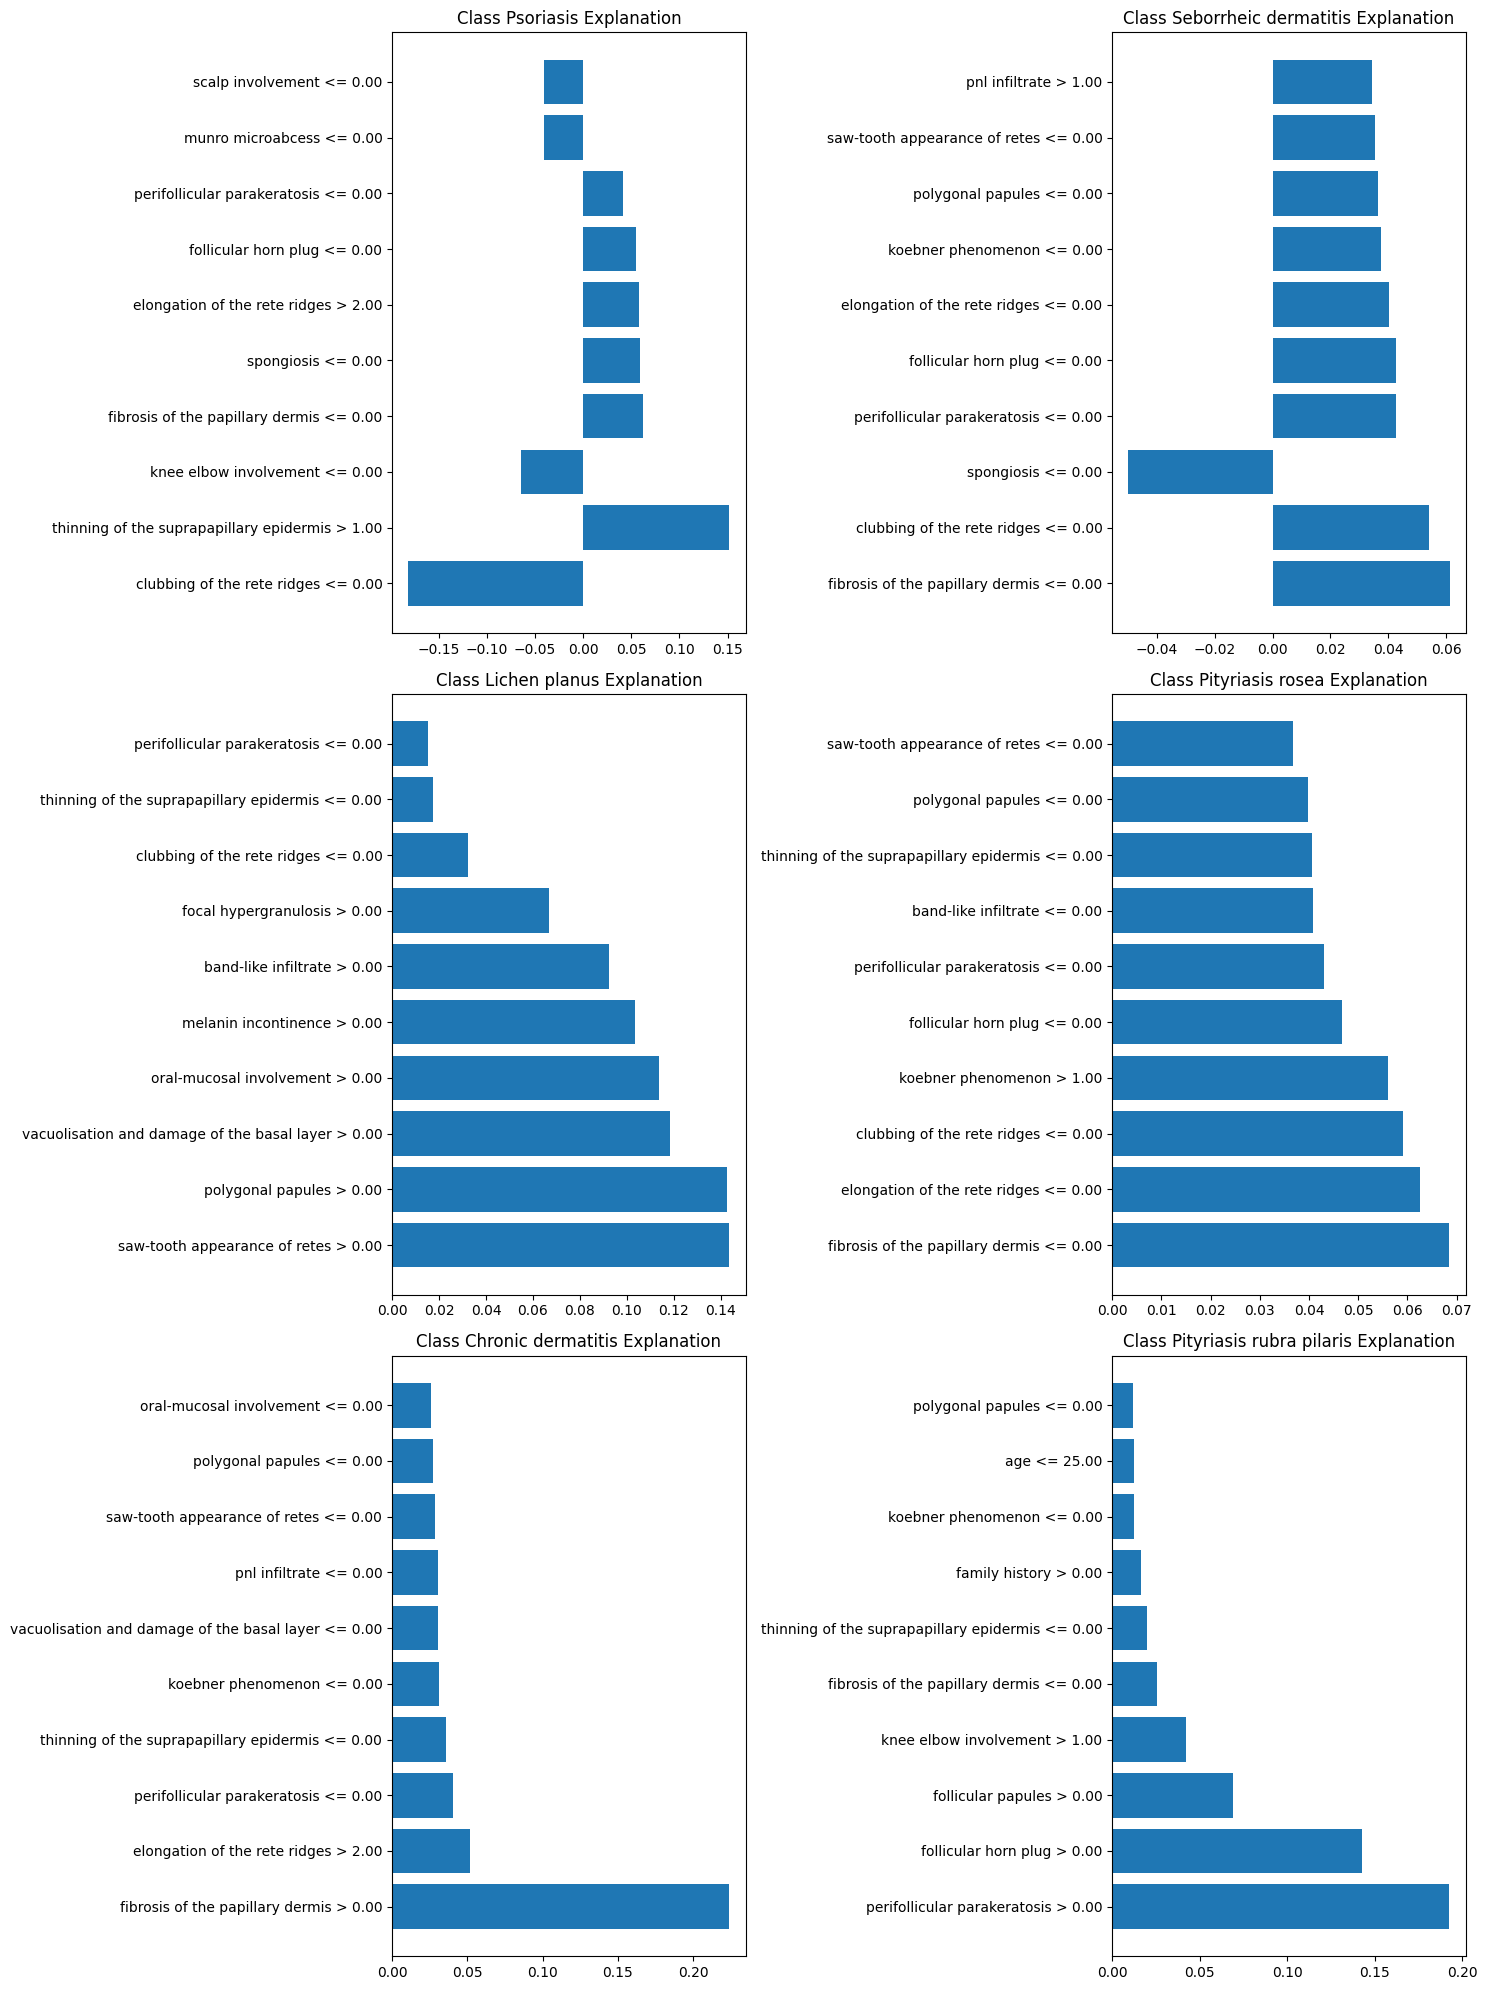

In [19]:
import joblib

# 1. Save the best model to a file
joblib.dump(best_pipeline, 'best_model.pkl')


# 2. Load the best model from the file
loaded_model = joblib.load('best_model.pkl')


# 3. Prepare LIME explainers
feature_names = X_train.columns.tolist()
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    class_names=[f'Class_{i}' for i in range(6)],
    verbose=False,
    mode='classification'
)

# 4. Create visualization figure
plt.figure(figsize=(20, 10))

# Create a grid for LIME explanations
fig, axes = plt.subplots(3, 2, figsize=(15, 20))  # Create figure and axes here
class_names = ['Psoriasis', 'Seborrheic dermatitis', 'Lichen planus', 'Pityriasis rosea',
               'Chronic dermatitis', 'Pityriasis rubra pilaris']

# Ensure we're working with numpy arrays
y_test_np = y_test.values if isinstance(y_test, (pd.Series, pd.DataFrame)) else y_test
X_test_np = X_test.values if isinstance(X_test, (pd.Series, pd.DataFrame)) else X_test

for class_idx in range(6):
    # Find indices for current class
    class_indices = np.where(y_test_np == class_idx)[0]

    if len(class_indices) == 0:
        print(f"Skipping class {class_idx} - no samples in test set")
        continue

    # Get first sample for the class
    sample_idx = class_indices[0]

    # Get explanation
    exp = explainer_lime.explain_instance(
        X_test_np[sample_idx],
        loaded_model.predict_proba,
        num_features=10,
        top_labels=1
    )

    # Plot in grid
    row = class_idx // 2
    col = class_idx % 2

    # Get the explanation as a list
    exp_list = exp.as_list(label=class_idx)

    # Create the LIME plot using the list and the specific subplot axis
    axes[row, col].barh([x[0] for x in exp_list], [x[1] for x in exp_list])
    axes[row, col].set_title(f"Class {class_names[class_idx]} Explanation")

plt.tight_layout()
plt.savefig('lime_explanations.png')
plt.show()

## LIME Visualization Analysis
The LIME visualizations provide critical insights into feature contributions for six different skin conditions. These visualizations reveal distinct histopathological signatures for each condition, highlighting which features most strongly influence the model's classification decisions. For instance, the visualization for psoriasis shows "thinning of the suprapapillary epidermis > 1.00" as the most significant positive contributor to classification, with a substantial rightward bar. "Spongiosis" and "fibrosis of the papillary dermis" also appear as important positive features. Interestingly, "clubbing of the rete ridges <= 0.00" has a strong negative influence, indicating its absence supports the psoriasis diagnosis. These findings align with psoriasis' clinical presentation, where epidermal thinning over dermal papillae is a characteristic histopathological feature.

The LIME visualizations reveal important patterns across conditions. Some features, such as "fibrosis of the papillary dermis," appear across multiple conditions but with varying importance and directional influence. For example, its presence strongly indicates chronic dermatitis, while its absence supports diagnoses of psoriasis and seborrheic dermatitis.





## SHAP Interpretation

In [20]:
# 2. Load saved model
loaded_model = joblib.load('best_model.pkl')

tree_model = loaded_model.named_steps['model']

# Initialize the KernelExplainer with the model's prediction function and training data
explainer = shap.TreeExplainer(tree_model)

# Compute SHAP values for the test set
shap_values_cat= explainer(X_test)

print(np.shape(shap_values_cat))


(74, 34, 6)


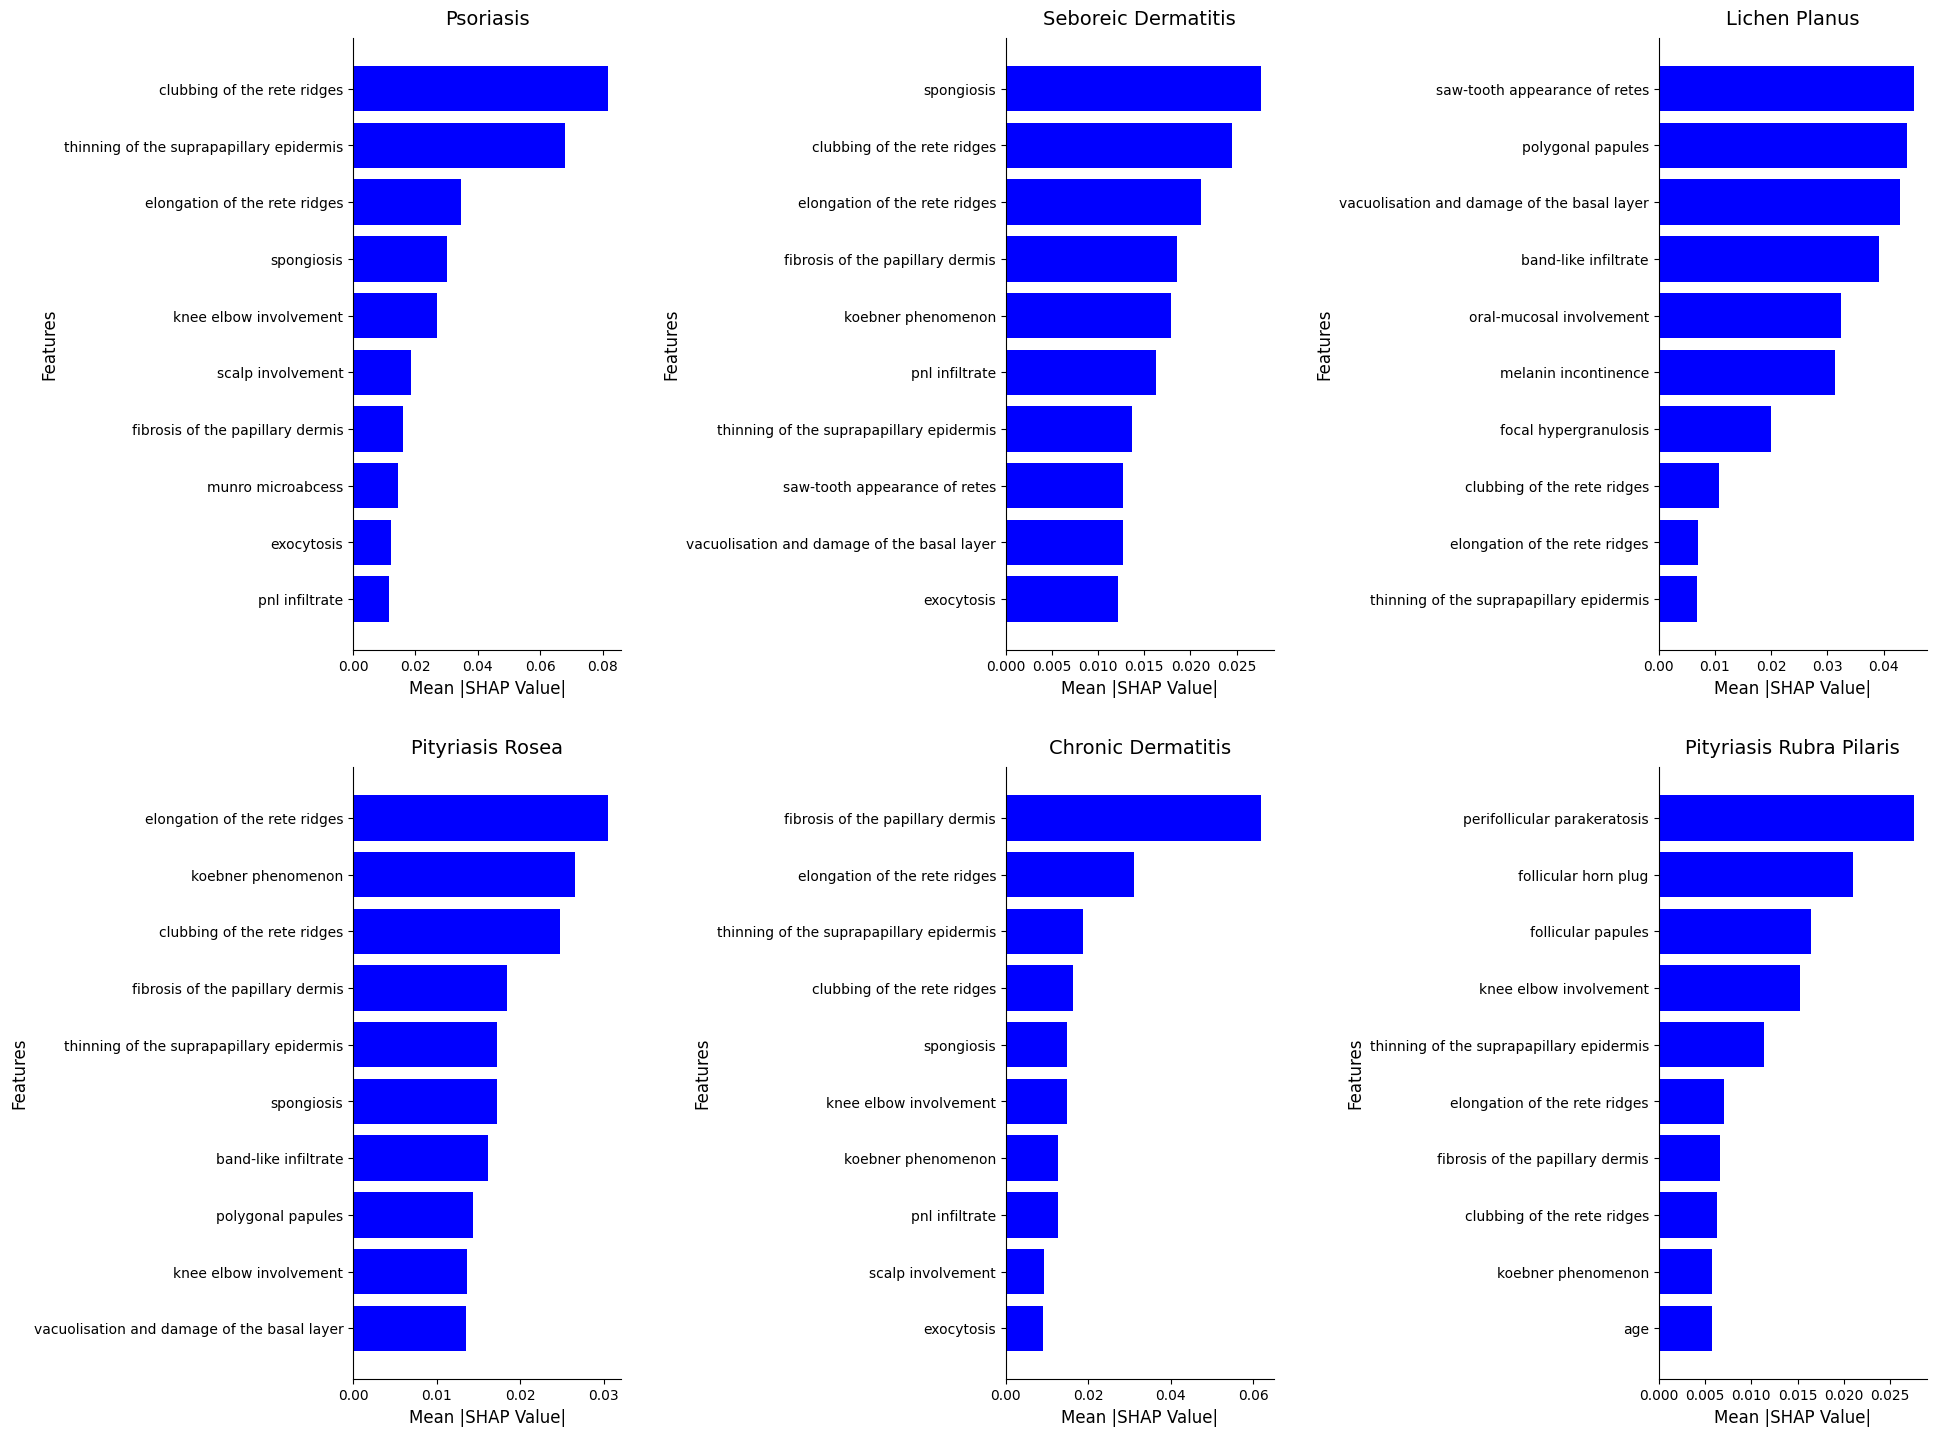

In [21]:
# 2. Load saved model
loaded_model = joblib.load('best_model.pkl')

# Assuming the model is inside a pipeline and is named 'model'
tree_model = loaded_model.named_steps['model']

# Initialize the TreeExplainer with the model's prediction function and training data
explainer = shap.TreeExplainer(tree_model, X_train)

# Compute SHAP values for the test set
shap_values_cat = explainer.shap_values(X_test)

#print(np.shape(shap_values_cat))  # Check the shape of the SHAP values

# Class names for dermatology dataset
class_names = [
    "Psoriasis",
    "Seboreic Dermatitis",
    "Lichen Planus",
    "Pityriasis Rosea",
    "Chronic Dermatitis",
    "Pityriasis Rubra Pilaris"
]

# Create figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.flatten()

# Plot SHAP summary for each class
for i, class_name in enumerate(class_names):
    # Select SHAP values for the current class
    shap_values_class = shap_values_cat[:,:,i]  # This is now (n_samples, n_features) for class i

    # Debug: Check if shap_values_class has the correct shape
    #print(f"Shape of SHAP values for {class_name}: {shap_values_class.shape}")

    if shap_values_class.shape[0] == 0:  # Check if the array is empty
        print(f"No SHAP values available for class: {class_name}. Skipping this class.")
        continue

    # Calculate mean absolute SHAP values for each feature (axis=0: mean over samples)
    mean_shap = np.abs(shap_values_class).mean(axis=0)

    # Debug: Check if mean_shap is empty
    #print(f"Mean SHAP values for {class_name}: {mean_shap}")

    if mean_shap.size == 0:  # Check if the mean_shap array is empty
        print(f"Empty mean SHAP values for class: {class_name}. Skipping this class.")
        continue

    # Sort features by importance
    sorted_idx = np.argsort(mean_shap)[-10:]  # Top 10 features
    sorted_vals = mean_shap[sorted_idx]
    sorted_names = [X_test.columns[j] for j in sorted_idx]

    # Create horizontal bar plot
    ax = axes[i]
    ax.barh(range(10), sorted_vals, align='center', color='blue')
    ax.set_yticks(range(10))
    ax.set_yticklabels(sorted_names, fontsize=10)
    ax.set_title(f"{class_name}", fontsize=14, pad=10)
    ax.set_xlabel("Mean |SHAP Value|", fontsize=12)
    ax.set_ylabel("Features", fontsize=12)
    ax.tick_params(axis='x', labelsize=10)

    # Remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout
plt.tight_layout(pad=3.0)

# Save and display
plt.savefig('dermatology_shap_summary_grid.png', dpi=300, bbox_inches='tight')
plt.show()


# SHAP Analysis of Feature Importance

The SHAP (SHapley Additive exPlanations) figure provides a detailed breakdown of feature importance across six dermatological conditions. For instance, the SHAP analysis for **psoriasis** identifies **"Clubbing of the rete ridges"** as the most influential feature, with a high positive SHAP value indicating its strong contribution to psoriasis classification. "Thinning of the suprapapillary epidermis" and "spongiosis" also emerge as significant contributors, reflecting important histopathological characteristics of psoriasis. Other features like "elongation of the rete ridges" and "fibrosis of the papillary dermis" play a secondary role but still provide meaningful contributions. The prominence of these features aligns with clinical findings, where epidermal changes and dermal inflammation are central to psoriasis pathology. In addition, the SHAP visualizations reveal several cross-condition patterns in feature importance. For example, while **"fibrosis of the papillary dermis"** is critical for **chronic dermatitis** classification, it plays a less significant role in other conditions like **psoriasis**. Similarly, features like "clubbing of the rete ridges" show variable importance across conditions—being highly influential for psoriasis but less so for **pityriasis rubra pilaris**.


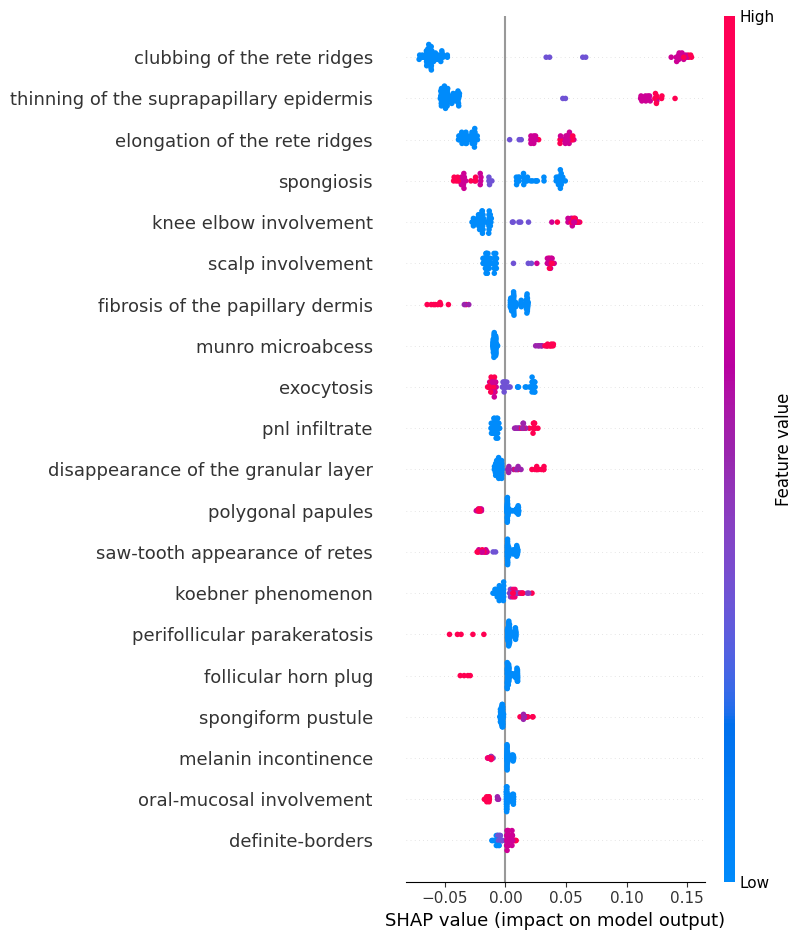

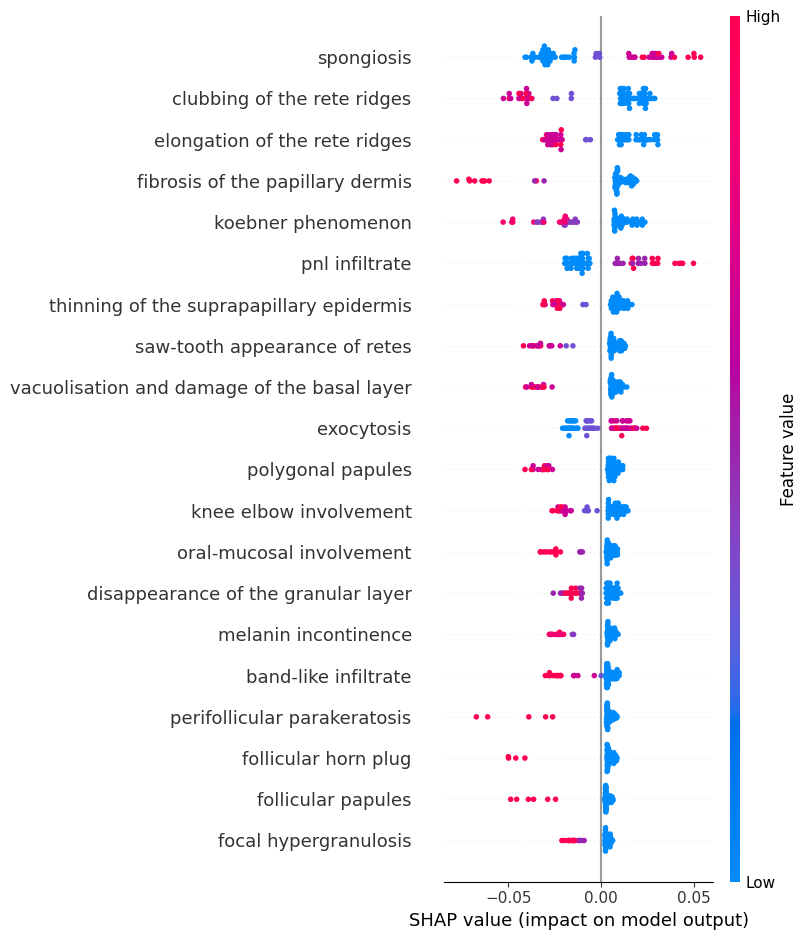

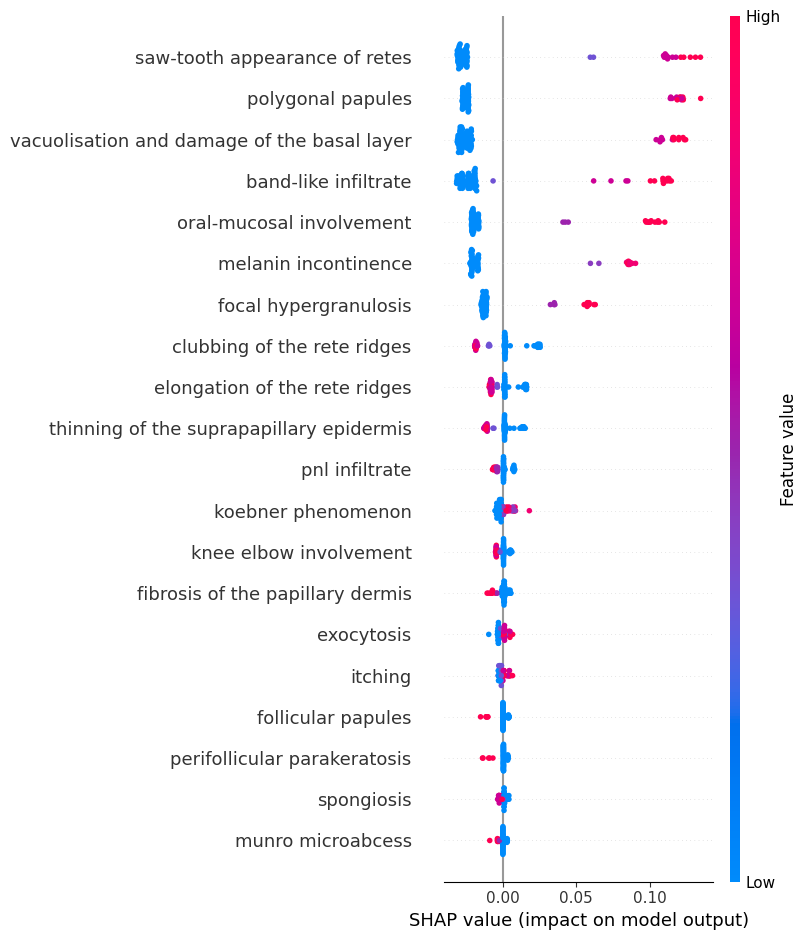

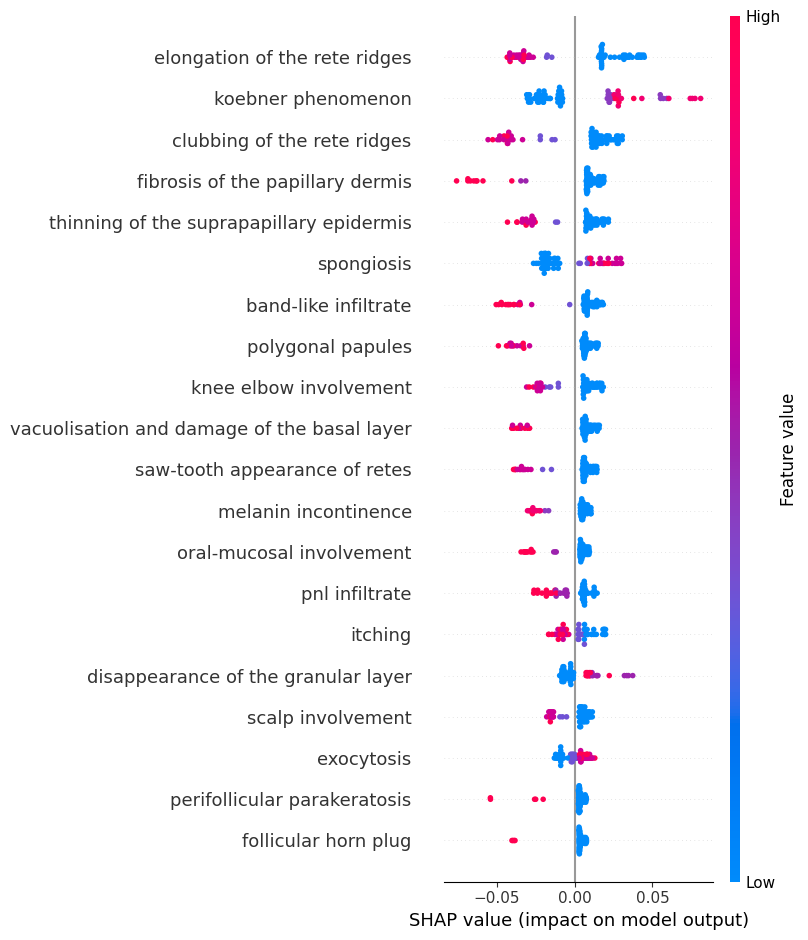

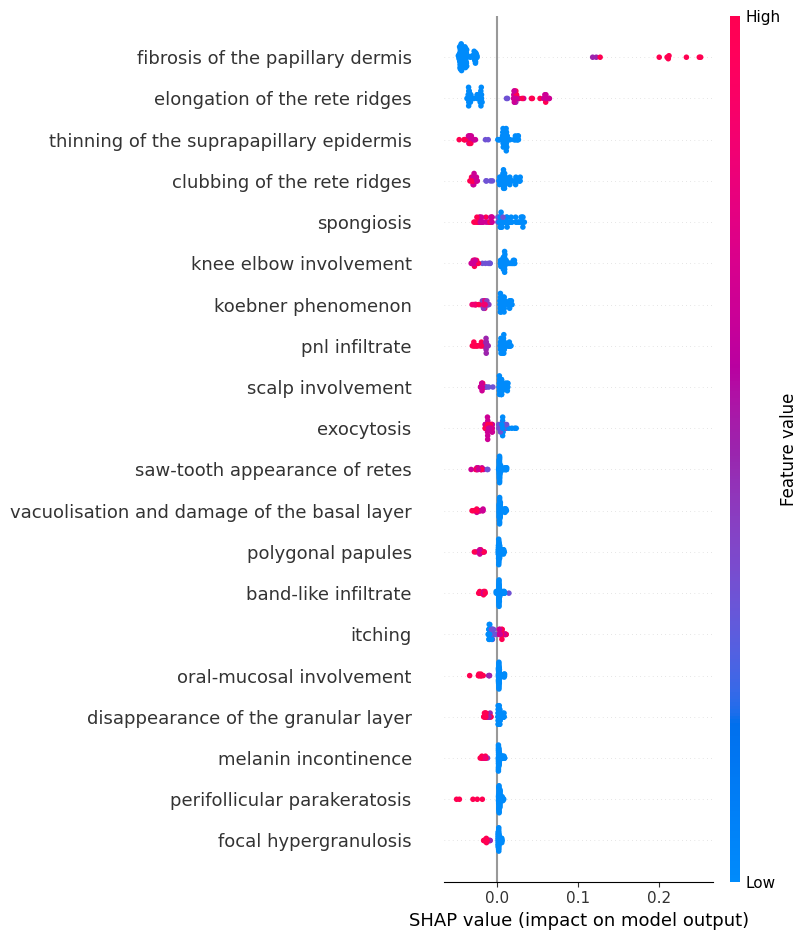

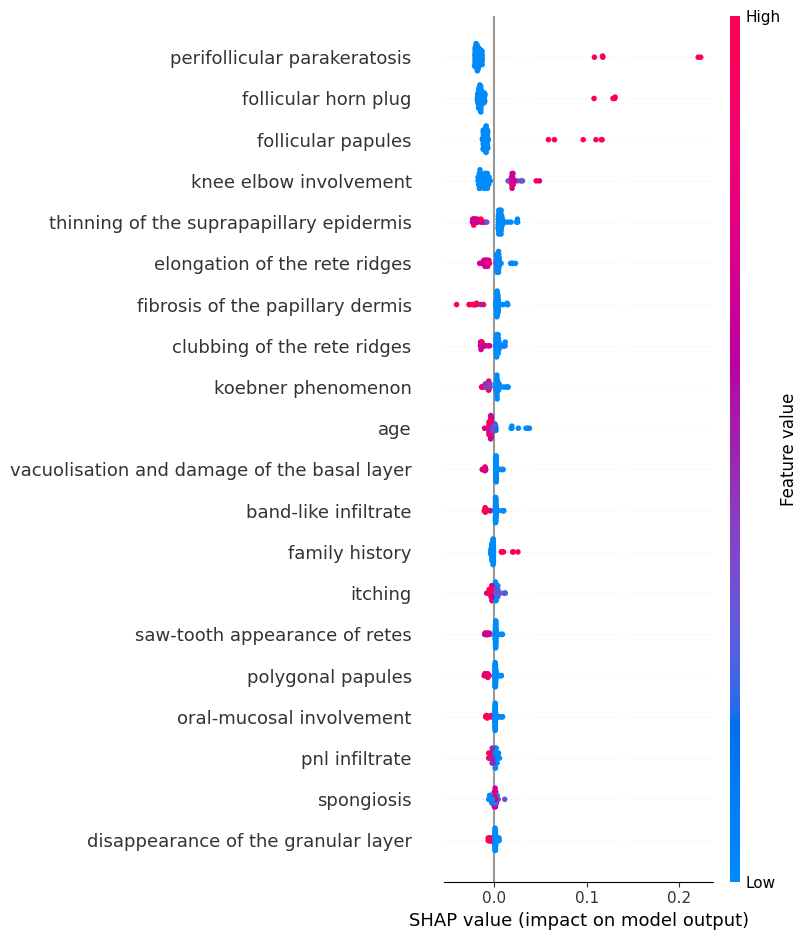

<Figure size 640x480 with 0 Axes>

In [22]:
# Class names for dermatology dataset
class_names = [
    "Psoriasis",
    "Seboreic Dermatitis",
    "Lichen Planus",
    "Pityriasis Rosea",
    "Chronic Dermatitis",
    "Pityriasis Rubra Pilaris"
]

# Create Tree SHAP explainer
explainer = shap.TreeExplainer(tree_model, X_train)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary for each class
for i, class_name in enumerate(class_names):
    # Select SHAP values for current class
    shap_values_class = shap_values[:,:,i]

    # Create summary plot in subplot
    shap.summary_plot(
        shap_values_class,
        X_test,
        title=class_name
    )


# Save and display
plt.savefig('dermatology_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

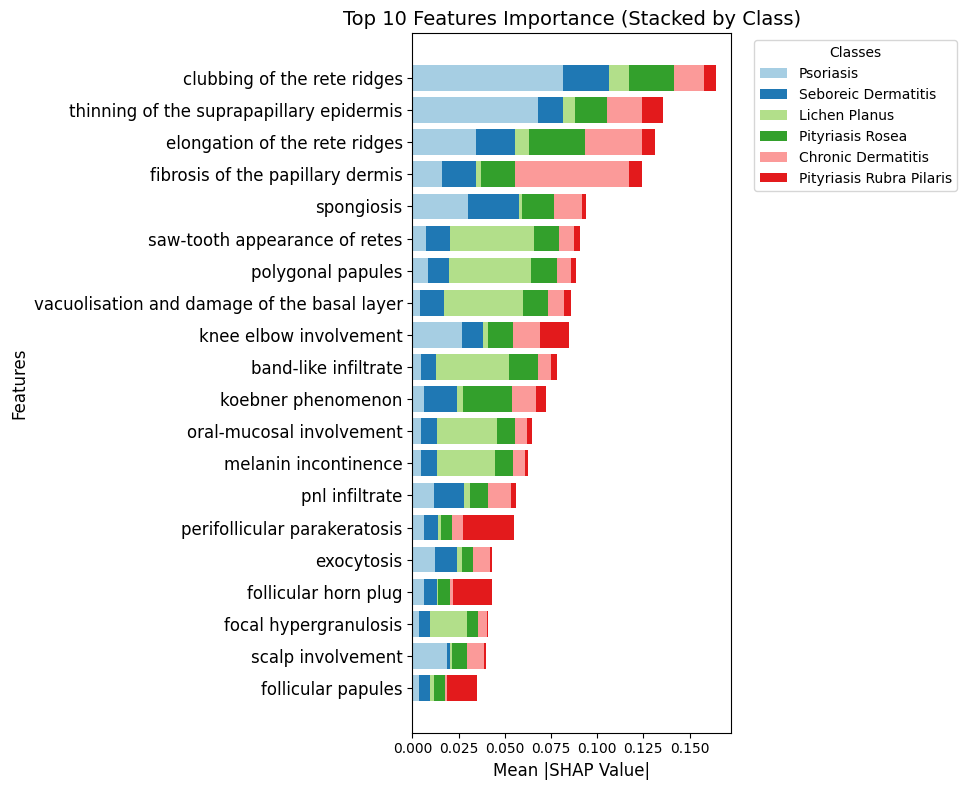

In [29]:
explainer = shap.TreeExplainer(tree_model, X_train)

# Compute SHAP values for the test set (multiclass output)
shap_values_cat = explainer.shap_values(X_test)

# Class names for dermatology dataset
class_names = [
    "Psoriasis",
    "Seboreic Dermatitis",
    "Lichen Planus",
    "Pityriasis Rosea",
    "Chronic Dermatitis",
    "Pityriasis Rubra Pilaris"
]

# Initialize a dictionary to store the mean absolute SHAP values for each feature across classes
mean_abs_shap = np.zeros((len(class_names), X_test.shape[1]))  # Shape (n_classes, n_features)

# Loop over each class and compute the mean absolute SHAP values for each feature
for i in range(len(class_names)):
    shap_values_class = shap_values_cat[:,:,i]  # (n_samples, n_features) for class i
    mean_abs_shap[i] = np.abs(shap_values_class).mean(axis=0)

# Calculate the total importance for each feature by summing the importance across all classes
feature_importance = np.sum(mean_abs_shap, axis=0)

# Get the top 10 most important features (sorted by total importance)
top_20_idx = np.argsort(feature_importance)[-20:]  # Top 20 features, sorted in descending order
top_20_feature_names = X_test.columns[top_20_idx]

# Plot stacked bar plot for the top 10 features
fig, ax = plt.subplots(figsize=(10, 8))

# Colors for each class
colors = plt.cm.Paired(range(len(class_names)))

# Plot each feature's contribution by class
for i in range(len(class_names)):
    ax.barh(range(20), mean_abs_shap[i, top_20_idx], label=class_names[i], color=colors[i], left=np.sum(mean_abs_shap[:i, top_20_idx], axis=0))

# Label the plot
ax.set_yticks(range(20))
ax.set_yticklabels(top_20_feature_names, fontsize=12)
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Top 10 Features Importance (Stacked by Class)', fontsize=14)

# Add a legend for the classes
ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and save
plt.tight_layout()
plt.savefig('shap_top_20_features_stacked.png', dpi=300, bbox_inches='tight')
plt.show()


# SHAP Bar Plot Analysis

The SHAP bar plot provides a comprehensive overview of feature importance across all classes. By aggregating the mean absolute SHAP values for each feature, the visualization highlights the average impact of individual histopathological features on model predictions across six dermatological conditions. For instance, the most impactful features across all classes include "clubbing of the rete ridges", "elongation of the rete ridges",  "thinning of the suprapapillary epidermis", and "spongiosis" These features consistently exhibit high mean SHAP values, indicating their significant contributions to distinguishing between dermatological conditions.

- **Clubbing of the rete ridges** emerges as the most influential feature overall, with substantial contributions across multiple conditions. Its prominence reflects its diagnostic relevance in disorders like psoriasis and seborrheic dermatitis, where epidermal structural changes are critical.
  - **Spongiosis**, a marker of intercellular edema in the epidermis, ranks second in importance. It plays a vital role in inflammatory conditions such as seborrheic dermatitis and chronic dermatitis.
  - **Elongation of the rete ridges** is another key feature with widespread impact across classes. This structural alteration is particularly relevant in psoriasis and pityriasis rosea.
  - **Thinning of the suprapapillary epidermis** is highly specific to psoriasis but also contributes moderately to other conditions.

  Features such as "vacuolisation and damage of the basal layer," "band-like infiltrate," "saw-tooth appearance of rete ridges exhibit moderate SHAP values. These features are more condition-specific but still contribute significantly to model predictions.

  - **Vacuolisation and damage of the basal layer** is particularly critical for lichen planus, reflecting its pathophysiological hallmark.
  - **Band-like infiltrate** aligns with lichen planus' characteristic lymphocytic infiltration at the dermoepidermal junction.
  - **Saw-tooth appearance of rete ridges** is another distinctive feature for lichen planus, while **Koebner phenomenon** contributes to psoriasis and pityriasis rosea.

## Clinical Implications

This SHAP analysis enhances interpretability by quantifying feature importance across all classes simultaneously. By identifying globally dominant features (e.g., clubbing of rete ridges) alongside condition-specific markers (e.g., vacuolisation for lichen planus), clinicians can better understand how machine learning models arrive at their predictions.